In [1]:
%load_ext jupyter_black

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

id_number = 8

val_percent_size = 0.20
test_percent_size = 0.20
X, y = fetch_california_housing(return_X_y=True)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=test_percent_size, random_state=id_number
)  # We keep 20% of data set to test
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_percent_size, random_state=id_number
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [6]:
X_train, y_train = torch.from_numpy(X_train).to(torch.float32), torch.from_numpy(
    y_train
).to(torch.float32).unsqueeze(1)
X_val, y_val = torch.from_numpy(X_val).to(torch.float32), torch.from_numpy(y_val).to(
    torch.float32
).unsqueeze(1)
X_test, y_test = torch.from_numpy(X_test).to(torch.float32), torch.from_numpy(
    y_test
).to(torch.float32).unsqueeze(1)

batch_size = 256
train_set = DataLoader(
    TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)
val_set = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_set = DataLoader(
    TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False
)

In [7]:
# An arbitrary large network that needs some regularization !
class RegressionModel(nn.Module):
    def __init__(self, n_features: int = 1) -> None:
        super(RegressionModel, self).__init__()
        self.n_features = n_features
        self.layers = nn.Sequential(
            nn.Linear(self.n_features, self.n_features),
            nn.ReLU(),
            nn.Linear(self.n_features, self.n_features),
            nn.ReLU(),
            nn.Linear(self.n_features, self.n_features),
            nn.ReLU(),
            nn.Linear(self.n_features, self.n_features),
            nn.ReLU(),
            nn.Linear(self.n_features, self.n_features),
            nn.ReLU(),
            nn.Linear(self.n_features, 1),
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layers(X)

In [12]:
def ridge_regul(model: RegressionModel, alpha: float = 1):
    """
    Inputs
        model: the neural network model to be optimized
        alpha: the regularization weight
    Outputs:
        a scalar corresponding to the regularization constraint
    """
    reg = 0.0
    
    for param in model.parameters():
        reg += torch.norm(param, p=2).pow(2)
    
    reg /= 2.0
    # You need to compute the regularization term here, as the sum 
    # of the square Euclidean norm of each layer weights
    # Hint: you can iterate over the parameters of a model with the 
    # following line of code
    # for param in model.parameters():
        
    return alpha * reg

In [13]:
learning_rate = 0.001
loss_fn = nn.MSELoss()
r2 = []

for alpha in np.logspace(-8, -2, 15):
    torch.manual_seed(id_number)
    model = RegressionModel(n_features=X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    n_epochs = 100
    train_set_len = len(train_set)
    val_set_len = len(val_set)
    train_loss, val_loss = [], []
    for epoch in range(n_epochs):
        # Set model to train mode
        model.train()
        accu = 0.0
        for X_, y_ in train_set:
            # Forward pass
            y_hat = model(X_)

            # Compute loss and add regularization term
            # TO BE COMPLETED
            loss = loss_fn(y_, y_hat)
            loss+=ridge_regul(model,alpha)
            accu += loss.item()

            # backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss.append(accu / train_set_len)

        # Validation
        model.eval()
        accu = 0.0
        with torch.no_grad():
            for X_, y_ in val_set:
                # Forward pass
                accu += loss_fn(model(X_), y_).item()
            val_loss.append(accu / val_set_len)
    with torch.no_grad():
        y_ = model(X_test)
        r2.append(r2_score(y_.detach().numpy(), y_test.detach().numpy()))

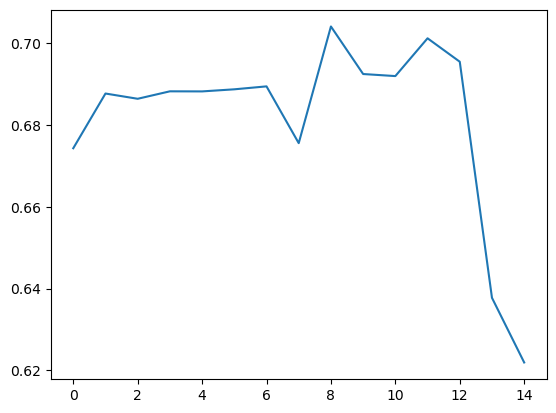

In [14]:
plt.plot(r2)